# **Physics-based loss and machine learing approach in application to fluids flow modelling: 3D flow in a pipe**
It is supposed that the Newtonian fluid flows through a cylindrical pipe with radius $R$. The flow is steady, the Reynolds number is smaller than the critical one $Re < Re^* {\approx} 1100...1400$ and the pipe length is greater than the critical one $L_3 > 0.16RRe$. 



# Initialization
## Import libraries

In [1]:
# Pytorch modules
import torch
from torch import nn

# Plotting
from matplotlib import pyplot as plt
from matplotlib import transforms
import numpy as np

# Python functions
from collections import namedtuple
from itertools import product
from collections import OrderedDict
#from scipy import integrate

# Status bar
from tqdm.notebook import tqdm
from datetime import datetime
import time

# Work with files and images
import json
from pathlib import Path
import os, fnmatch
import re
from PIL import Image

#Log
import neptune.new as neptune
from neptune.new.types import File

import time

## Download and preprocess image of the flow domain

## Path

In [2]:
path =  Path('/root/Physics_based_loss')
imgPath = path/'ToyDataset'
imgList = fnmatch.filter(os.listdir(imgPath), '*.pt') #imgPath.ls()
imgList
#Image number from the imgList
imgNo = 0
print(imgList, imgNo)

['pipe_tensor.pt'] 0


Download 3D image

In [3]:
img = torch.load(os.path.join(imgPath, imgList[imgNo]))
imgDim = img.shape[1:]
print(f'image shape: {imgDim}')

image shape: torch.Size([128, 128, 128])


## Constants

In [4]:
SIZE = imgDim
#Training
EPOCHS = 100000
NoOfFeatures = 32 #32
WORK_DIR = '/root/Physics_based_loss'
IN_CH = 1 #number of input channels
OUT_CH = 1#number of output channels
#Loss regularization
REG_LOSS_COEF = 1000000

#SCALE_FACTOR = 1 # muliplier for the loss function
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_NAME = "unet"
EARLY_STOP_PATIENCE = EPOCHS
DECAY = 1e-4
PATIENCE = 0

parameters = {'image_size':SIZE,
             'Epochs':EPOCHS,
             'Model':MODEL_NAME,
             'No_of_features':NoOfFeatures}

HYPS = []

hyps = {"Epochs":[EPOCHS],
        "learning_rate": [1e-4],
        "scheduler": ["none"],
        "scheduler_factor": [0.5],
        "scheduler_patience": [int(EPOCHS*0.05)],
        "use_bn": [True],
        "Early_stop_patience": [EARLY_STOP_PATIENCE],
        "Decay": [DECAY]} # Use or not batchnorm
    
for i in product(*[hyps[j] for j in hyps]):
    HYPS.append({a:b for a, b in zip(hyps, i)})
#"scheduler": ["None", "step", "cycle"]
#"use_bn": [True, False]

#Visualization
slices = [int(imgDim[0]/2), int(imgDim[1]/2), int(imgDim[2]/2)]
vps = 10 #vector plot step 
FIGSIZE = 5 # figure size

## Geometry of the flow domain, fluid properties and boundary conditions

Geometry

It is convenient to present the flow domain $\Omega$ in the form of a parallelepiped $x_i^- < x_i < x_i^+$ ($\boldsymbol{L} = [l_i] = [x_i^+ - x_i^-]$, $i = 1,2,3$).

In [5]:
# L_1 x L_2 x L_3 flow domain
L = [0.008, 0.008, 0.52]#, [m]
R = L[0]/2 #, [m]

# Normalized coordinates, normalized finite diferences, limits and elementary volume
X1N = torch.linspace(0, 1, SIZE[0])
X2N = torch.linspace(0, 1, SIZE[1])
X3N = torch.linspace(0, 1, SIZE[2])

DX1N = X1N[1] - X1N[0]
DX2N = X2N[1] - X2N[0]
DX3N = X3N[1] - X3N[0]

LIM1 = [0, L[0]]
LIM2 = [0, L[1]]
LIM3 = [0, L[2]]

dOmega = DX1N * DX2N * DX3N * L[0] * L[1] * L[2] # elementary volume

Boundary conditions
1. The values of the flow rates $Q_i(x_i^-)$, $Q_i(x_i^+)$ through the edges $x_i = x_i^-$, $x_i = x_i^+$ of the flow domain are given:

In [6]:
#Flow rates Q1-,Q2-,Q3-
Qm = [0, 0, -1E-5]

#Flow rates Q1+,Q2+,Q3+
Qp = [0, 0, 1E-5]

2. NL layers have fixed values of the unknown function $\boldsymbol\Psi$.

In [7]:
DVTEMP = 'sc' #template for the velocity function differentiation
if  DVTEMP == 'sc':
    NL = 3
elif DVTEMP == 'fc':
    NL = 5

Properties of non-Newtonian fluid and walls that are relatively rigid body.
The Herschel-Bulkley law is applied:
\begin{equation}
    \mu(H)=q_0+q_1H^{z-1},
\end{equation}
where $q_0$, $q_1$, $z$ are the parameters obtained from rheological tests.

In [8]:
#Non-Newtonian fluid viscosity
Q0 = 4e-3
Q1 = 0
Z = 1
# Fluid density, kg/m**3
RHO = 1000
#Newtonian fluid analogue
MU = Q0

#Critical Reynolds number
Re_cr = 1100

#Walls viscosity
Q0W = 1e+0#1e-0#1e+3eye 
Q1W = 0#1e-0
ZW =1#0.5

## Additional functions

3D numerical derivative

In [9]:
def num_diff(f,dx1,dx2,dx3,template='sc'):
    '''The following templates are applied:
    sc - second-order central difference,
    fc - fifth-order central difference.
    Indexing:
    i - index along x_1,
    j - index along x_2,
    k - index along x_3.
    '''
    #Shape
    n1, n2, n3 = f.shape
    
    df_dx1, df_dx2, df_dx3 = torch.zeros(n1, n2, n3), torch.zeros(n1, n2, n3), torch.zeros(n1, n2, n3)
    
    #Device
    if torch.cuda.is_available():
        df_dx1 = df_dx1.to('cuda')
        df_dx2 = df_dx2.to('cuda')
        df_dx3 = df_dx3.to('cuda')
    
    #Derivatives
    if template == 'sc':
        # x1 derivative:
        df_dx1[1:n1-1,:,:] = (f[2:,:,:] - f[:-2,:,:]) / (2 * dx1)
        df_dx1[0,:,:] = (-f[2,:,:] + 4 * f[1,:,:] - 3 * f[0,:,:]) / (2 * dx1)
        df_dx1[n1-1,:,:] = (3 * f[n1-1,:,:] - 4 * f[n1-2,:,:] + f[n1-3,:,:]) / (2 * dx1)
        # x2 derivative:
        df_dx2[:,1:n2-1, :] = (f[:, 2:, :] - f[:, :-2, :]) / (2 * dx2)
        df_dx2[:,0, :] = (- f[:,2,:] + 4 * f[:,1,:] - 3 * f[:, 0, :]) / (2 * dx2)
        df_dx2[:,n2-1, :] = (3 * f[:, n2 - 1, :] - 4 * f[:, n2 - 2, :] + f[:, n2 - 3, :]) / (2 * dx2)
        # x3 derivative:
        df_dx3[:, :, 1:n3-1] = (f[:,:,2:] - f[:,:,:-2]) / (2 * dx3)
        df_dx3[:, :, 0] = (- f[:, :, 2] + 4 * f[:, :, 1] - 3 * f[:, :, 0]) / (2 * dx3)
        df_dx3[:, :, n3-1] = (3 * f[:, :, n3 - 1] - 4 * f[:, :, n3 - 2] + f[:, :, n3 - 3]) / (2 * dx3)
    elif template == 'fc':
        # x1 derivative
        df_dx1[2:n1-2, :, :] = (-f[4:, :,:] + 8 * f[3:n1-1, :, :] - 8 * f[1:n1-3, :, :] + f[:n1-4, :, :]) / (12 * dx1)
        df_dx1[0, :, :] = (-3 * f[4, :, :] + 16 * f[3, :, :] - 36 * f[2, :, :] + 48 * f[1, :,:] - 25 * f[0, :, :]) / (12 * dx1)
        df_dx1[1, :, :] = (f[4, :, :] - 6 * f[3, :, :] + 18 * f[2, :, :] - 10 * f[1, :, :] - 3 * f[0, :, :]) / (12 * dx1)
        df_dx1[n1-2, :, :] = (3 * f[n1-1, :, :] + 10 * f[n1-2, :, :] - 18 * f[n1-3, :, :] + 6 * f[n1-4, :, :] - f[n1-5, :, :]) / (12 * dx1)
        df_dx1[n1-1, :, :] = (25 * f[n1-1, :, :] - 48 * f[n1-2, :, :] + 36 * f[n1-3, :, :] - 16 * f[n1-4, :, :] + 3*f[n1-5, :, :]) / (12 * dx1)
        
        # x2 derivative
        df_dx2[:, 2:n2-2, :] = (-f[:, 4:, :] + 8 * f[:, 3:n2-1, :] - 8 * f[:, 1:n2-3, :] + f[:, :n2-4, :]) / (12 * dx2)
        df_dx2[:, 0, :] = (-3 * f[:,4, :] + 16 * f[:, 3, :] - 36 * f[:, 2, :] + 48 * f[:, 1, :] - 25 * f[:, 0, :]) / (12*dx2)
        df_dx2[:, 1, :] = (f[:, 4, :] - 6 * f[:, 3, :] + 18 * f[:, 2, :] - 10 * f[:, 1, :] - 3 * f[:, 0, :]) / (12*dx2)
        df_dx2[:, n2-2, :] = (3 * f[:, n2-1, :] + 10 * f[:, n2-2, :] - 18 * f[:, n2-3, :] + 6 * f[:, n2-4, :] - f[:, n2-5, :]) / (12*dx2)
        df_dx2[:, n2-1, :] = (25 * f[:, n2-1, :] - 48 * f[:, n2-2, :] + 36 * f[:, n2-3, :] - 16 * f[:, n2-4, :] + 3 * f[:,n2-5, :]) / (12*dx2)       
        # x3 derivative
        df_dx3[:, :, 2:n3-2] = (-f[:, :, 4:] + 8 * f[:, :, 3:n3-1] - 8 * f[:, :, 1:n3-3] + f[:, :, :n3-4]) / (12 * dx3)
        df_dx3[:, :, 0] = (-3 * f[:, :, 4] + 16 * f[:, :, 3] - 36 * f[:, :, 2] + 48 * f[:, :, 1] - 25 * f[:, :, 0]) / (12 * dx3)
        df_dx3[:, :, 1] = (f[:, :, 4] - 6 * f[:, :, 3] + 18 * f[:, :, 2] - 10 * f[:, :, 1] - 3 * f[:, :, 0]) / (12 * dx3)
        df_dx3[:, :, n3-2] = (3 * f[:, :, n3-1] + 10 * f[:, :, n3-2] - 18 * f[:, :, n3-3] + 6 * f[:,:,n3-4] - f[:, :, n3-5]) / (12 * dx3)
        df_dx3[:, :, n3-1] = (25 * f[:,:, n3-1] - 48 * f[:,:, n3-2] + 36 * f[:,:, n3-3] - 16 * f[:,:, n3-4] + 3*f[:,:, n3-5]) / (12 * dx3)
    
    return df_dx1, df_dx2, df_dx3

2D numerical derivative

In [10]:
def num_diff2D(f,dx1,dx2,template=DVTEMP):
    '''The following templates are applied:
    sc - second-order central difference,
    fc - fifth-order central difference.
    Indexing:
    i - index along x_1,
    j - index along x_2.
    '''
    #Shape
    n1, n2 = f.shape
    
    df_dx1, df_dx2 = torch.zeros(n1, n2), torch.zeros(n1, n2)
    
    #Device
    if torch.cuda.is_available():
        df_dx1 = df_dx1.to('cuda')
        df_dx2 = df_dx2.to('cuda')
            
    #Derivatives
    if template == 'sc':
        # x1 derivative:
        df_dx1[1:n1-1,:] = (f[2:,:] - f[:-2,:]) / (2 * dx1)
        df_dx1[0,:] = (-f[2,:] + 4 * f[1,:] - 3 * f[0,:]) / (2 * dx1)
        df_dx1[n1-1,:] = (3 * f[n1-1,:] - 4 * f[n1-2,:] + f[n1-3,:]) / (2 * dx1)
        # x2 derivative:
        df_dx2[:,1:n2-1] = (f[:, 2:] - f[:, :-2]) / (2 * dx2)
        df_dx2[:,0] = (- f[:,2] + 4 * f[:,1] - 3 * f[:, 0]) / (2 * dx2)
        df_dx2[:,n2-1] = (3 * f[:, n2 - 1] - 4 * f[:, n2 - 2] + f[:, n2 - 3]) / (2 * dx2)
    elif template == 'fc':
        # 1st order x1 derivative:
        # x1 derivative
        df_dx1[2:n1-2, :] = (-f[4:, :] + 8 * f[3:n1-1, :] - 8 * f[1:n1-3, :] + f[:n1-4, :]) / (12 * dx1)
        df_dx1[0, :] = (-3 * f[4, :] + 16 * f[3, :] - 36 * f[2, :] + 48 * f[1, :] - 25 * f[0, :]) / (12 * dx1)
        df_dx1[1, :] = (f[4, :] - 6 * f[3, :] + 18 * f[2, :] - 10 * f[1, :] - 3 * f[0, :]) / (12 * dx1)
        df_dx1[n1-2, :] = (3 * f[n1-1, :] + 10 * f[n1-2, :] - 18 * f[n1-3, :] + 6 * f[n1-4, :] - f[n1-5, :]) / (12 * dx1)
        df_dx1[n1-1, :] = (25 * f[n1-1, :] - 48 * f[n1-2, :] + 36 * f[n1-3, :] - 16 * f[n1-4, :] + 3*f[n1-5, :]) / (12 * dx1)
        
        # x2 derivative
        df_dx2[:, 2:n2-2] = (-f[:, 4:] + 8 * f[:, 3:n2-1] - 8 * f[:, 1:n2-3] + f[:, :n2-4]) / (12 * dx2)
        df_dx2[:, 0] = (-3 * f[:,4] + 16 * f[:, 3] - 36 * f[:, 2] + 48 * f[:, 1] - 25 * f[:, 0]) / (12*dx2)
        df_dx2[:, 1] = (f[:, 4] - 6 * f[:, 3] + 18 * f[:, 2] - 10 * f[:, 1] - 3 * f[:, 0]) / (12*dx2)
        df_dx2[:, n2-2] = (3 * f[:, n2-1] + 10 * f[:, n2-2] - 18 * f[:, n2-3] + 6 * f[:, n2-4] - f[:, n2-5]) / (12*dx2)
        df_dx2[:, n2-1] = (25 * f[:, n2-1] - 48 * f[:, n2-2] + 36 * f[:, n2-3] - 16 * f[:, n2-4] + 3 * f[:,n2-5]) / (12*dx2)    
    
    return df_dx1, df_dx2

3D numerical integration (Simpson method)

In [11]:
def int_func_simpson_3d(f, dx, dy, dz):
  '''
  f - 3d-dimentional tensor
  dx, dy, dz - constant step along the corresponding coordinate
  '''
  n1,n2,n3 = f.shape
  # integrate by dz:
  if n3%2 == 0:
    J3 = (f[:,:,0:n3-2:2] + 4*f[:,:,1:n3-2:2] + f[:,:,2::2]).sum(dim=2)*dz/3 + (f[:,:,-1]+f[:,:,-2])*dz/2
  else:
    J3 = (f[:,:,0:n3-1:2] + 4*f[:,:,1:n3-1:2] + f[:,:,2::2]).sum(dim=2)*dz/3

  # integrate by dy:
  if n2%2 == 0:
    J2 = (J3[:,0:n2-2:2] + 4*J3[:,1:n2-2:2] + J3[:,2::2]).sum(dim=1)*dy/3 + (J3[:,-1]+J3[:,-2])*dy/2
  else:
    J2 = (J3[:,0:n2-1:2] +4 *J3[:,1:n2-1:2] + J3[:,2::2]).sum(dim=1)*dy/3

  # integrate by dx:
  if n1%2 == 0:
    J1 = (J2[0:n1-2:2] + 4*J2[1:n1-2:2] + J2[2::2]).sum(dim=0)*dx/3 + (J2[-1]+J2[-2])*dx/2
  else:
    J1 = (J2[0:n1-1:2] + 4*J2[1:n1-1:2] + J2[2::2]).sum(dim=0)*dx/3

  return J1

2D numerical integration (Simpson method)

In [12]:
def int_func_simpson_2d(f, dx, dy):
  '''
  f - 2d-dimentional tensor
  dx, dy - constant step along the corresponding coordinate
  '''
  n1, n2 = f.shape
  # integrate by dy:
  if n2%2 == 0:
    J2 = (f[:,0:n2-2:2]+ 4*f[:,1:n2-2:2] + f[:,2::2]).sum(dim=1)*dy/3 + (f[:,-1]+f[:,-2])*dy/2
  else:
    J2 = (f[:,0:n2-1:2] +4*f[:,1:n2-1:2]+f[:,2::2]).sum(dim=1)*dy/3
  # integrate by dx:
  if n1%2 == 0:
    J1 = (J2[0:n1-2:2]+ 4*J2[1:n1-2:2] + J2[2::2]).sum(dim=0)*dx/3 + (J2[-1]+J2[-2])*dx/2
  else:
    J1 = (J2[0:n1-1:2] +4*J2[1:n1-1:2]+J2[2::2]).sum(dim=0)*dx/3
  return J1

Visualization

In [13]:
def vector_plot(x, y, u, v, FIGSIZE, vptitle='vector_plot', xlabel='$x_i$', ylabel='$x_j$',step=10):
    gradmag = np.sqrt(u**2 + v**2)
    plt.pcolor(x, y, gradmag, cmap='rainbow')
    plt.colorbar()
    plt.quiver(x[::step,::step], y[::step,::step], u[::step,::step], v[::step,::step])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(vptitle)

In [14]:
def vector_plot_3d(x, v, figSize=FIGSIZE, step=1):
    fig = plt.figure(figsize=(figSize, figSize))
    ax = fig.add_subplot(projection='3d')
    ax.quiver(x[0], x[1], x[2], v[::step, ::step, ::step, 0], v[::step, ::step, ::step, 1], v[::step, ::step, ::step, 2], length=5, normalize=True)
    pos = np.where(img[0].rot90().cpu().detach()==1)
    ax.scatter(pos[1], pos[0], pos[2], c='red', s=0.5, alpha=0.2)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.bar3d(0, 0, 0., SIZE[0], SIZE[1], SIZE[2], alpha=0.1, edgecolor='black', color='black')
    plt.show()

In [15]:
def flowVisualization(psi,step=15,slices=slices):
    nr=2
    nc=len(SIZE)
    
    #Velocity distribution
    v1, v2, v3 = velocityDistr(psi[0,0,:,:].to('cpu'), psi[0,1,:,:].to('cpu'), psi[0,2,:,:].to('cpu'),
                               DX1N.to('cpu'), DX2N.to('cpu'), DX3N.to('cpu'),
                               L[0], L[1], L[2])
    V = torch.stack([v1.to('cpu'),v2.to('cpu'),v3.to('cpu')])
    Vabs = torch.sqrt(v1.to('cpu')**2 + v2.to('cpu')**2 + v3.to('cpu')**2)
    
    print('Psi function Visualization')
    fig = plt.figure(figsize=(FIGSIZE*nc, FIGSIZE*nr))
    for i in range(len(SIZE)):
        plt.subplot(nr,nc,i+1)
        plt.imshow(psi[0,i,::].to('cpu'))
        plt.title(f'$\psi_{i+1}$')
        plt.subplot(nr,nc,i+1+nc)
        plt.plot(psi[0,i,:,slices[i]].to('cpu'))
        plt.grid()
    plt.show()
    
    print(f'Q1+ = {- (psi[0,1,-1,-1] - psi[0,1,-1,0])*L[1] + (psi[0,2,-1,-1] - psi[0,2,-1,0])*L[2]}, target value: {Qp[0]},')
    print(f'Q2+ = {- (psi[0,2,-1,-1] - psi[0,2,0,-1])*L[2] + (psi[0,0,-1,-1] - psi[0,0,-1,0])*L[0]}, target value: {Qp[1]},')
    print(f'Q3+ = {- (psi[0,0,-1,-1] - psi[0,0,0,-1])*L[0] + (psi[0,1,-1,-1] - psi[0,1,0,-1])*L[1]}, target value: {Qp[2]}')
    
    print()
    print('Velocity distribution visualization without flow domain mask (first line) and with mask (second line)')

    XN = torch.meshgrid(X1N,X2N,X3N)
    
    fig1 = plt.figure(figsize=(FIGSIZE*nc, FIGSIZE*nr))
    #without flow domain mask 
    plt.subplot(nr,nc,1)
    vector_plot(XN[1][0,:,:], XN[2][0,:,:], V[1,slices[0],:,:], V[2,slices[0],:,:],
                FIGSIZE, vptitle='$x_1 = const$', xlabel='$x_3$', ylabel='$x_2$', step=step)
    plt.subplot(nr,nc,2)
    vector_plot(XN[0][:,0,:], XN[2][:,0,:], V[0,:,slices[1],:], V[2,:,slices[1],:],
                FIGSIZE, vptitle='$x_2 = const$', xlabel='$x_3$', ylabel='$x_1$', step=step)
    plt.subplot(nr,nc,3)
    vector_plot(XN[0][:,:,0], XN[1][:,:,0], V[0,:,:,slices[2]], V[1,:,:,slices[2]],
                FIGSIZE, vptitle='$x_3 = const$', xlabel='$x_2$', ylabel='$x_1$', step=step)
    #with flow domain mask 
    plt.subplot(nr,nc,4)
    vector_plot(XN[1][0,:,:], XN[2][0,:,:], V[1,slices[0],:,:]*img[0,slices[0],:,:].to('cpu'), V[2,slices[0],:,:]*img[0,slices[0],:,:].to('cpu'),
                FIGSIZE, vptitle='$x_1 = const$', xlabel='$x_3$', ylabel='$x_2$', step=step)
    plt.subplot(nr,nc,5)
    vector_plot(XN[0][:,0,:], XN[2][:,0,:], V[0,:,slices[1],:]*img[0,:,slices[1],:].to('cpu'), V[2,:,slices[1],:]*img[0,:,slices[1],:].to('cpu'),
                FIGSIZE, vptitle='$x_2 = const$', xlabel='$x_3$', ylabel='$x_1$', step=step)
    plt.subplot(nr,nc,6)
    vector_plot(XN[0][:,:,0], XN[1][:,:,0], V[0,:,:,slices[2]]*img[0,:,:,slices[2]].to('cpu'), V[1,:,:,slices[2]]*img[0,:,:,slices[2]].to('cpu'),
                FIGSIZE, vptitle='$x_3 = const$', xlabel='$x_2$', ylabel='$x_1$', step=step)
    
    #Check the flow rates Q3-,Q3+
    Q1mch = int_func_simpson_2d(V[0, 0, :, :], L[1]*DX2N.to('cpu'), L[2]*DX3N.to('cpu'))
    Q1pch = int_func_simpson_2d(V[0,-1, :, :], L[1]*DX2N.to('cpu'), L[2]*DX3N.to('cpu'))
    
    Q2mch = int_func_simpson_2d(V[1, :, 0, :], L[0]*DX1N.to('cpu'), L[2]*DX3N.to('cpu'))
    Q2pch = int_func_simpson_2d(V[1, :,-1, :], L[0]*DX1N.to('cpu'), L[2]*DX3N.to('cpu'))
    
    Q3mch = int_func_simpson_2d(V[2, :, :, 0], L[0]*DX1N.to('cpu'), L[1]*DX2N.to('cpu'))
    Q3pch = int_func_simpson_2d(V[2, :, :,-1], L[0]*DX1N.to('cpu'), L[1]*DX2N.to('cpu'))
    
    print(f'{V[0].min()} < v_1 < {V[0].max()},')
    print(f'{V[1].min()} < v_2 < {V[1].max()},')
    print(f'{V[2].min()} < v_3 < {V[2].max()},')
    print(f'Q1- = {Q1mch}, Q1+ = {Q1pch}')
    print(f'Q2- = {Q2mch}, Q2+ = {Q2pch}')
    print(f'Q3- = {Q3mch}, Q3+ = {Q3pch}')
    
    print(f'Vabs[0,0,0] = {Vabs[0,0,0]}, Vabs[0,0,-1] = {Vabs[0,0,-1]}, Vabs[0,-1,0] = {Vabs[0,-1,0]}, Vabs[0,-1,-1] = {Vabs[0,-1,-1]}, Vabs[-1,0,0] = {Vabs[-1,0,0]}, Vabs[-1,0,-1] = {Vabs[-1,0,-1]}, Vabs[-1,-1,0] = {Vabs[-1,-1,0]}, Vabs[-1,-1,-1] = {Vabs[-1,-1,-1]},')
  
    return    

## Major functions

For any given function $\boldsymbol\Psi = [\psi_i]$ that has fixed values on the boundaries of the flow domain together with its first, second, and third derivatives, the velocity distribution can be expressed in compact or in expanded form, respectively:
\begin{equation} 
    \boldsymbol{V} = 
    \begin{bmatrix}
    \epsilon_{ijk}
    \frac{\partial \psi_k(x_i,x_j)}{\partial x_j}
    \end{bmatrix},
\end{equation}
where $\epsilon_{ijk}$ is the Levi-Civita symbol,

\begin{equation} 
    \boldsymbol{V} = 
    \begin{bmatrix}
    \frac{\partial \psi_3}{\partial x_2} - \frac{\partial \psi_2}{\partial x_3}, &
    \frac{\partial \psi_1}{\partial x_3} - \frac{\partial \psi_3}{\partial x_1}, &
    \frac{\partial \psi_2}{\partial x_1} - \frac{\partial \psi_1}{\partial x_2}
    \end{bmatrix}.
\end{equation} 

In [16]:
def velocityDistr(psi1,psi2,psi3,dx1n,dx2n,dx3n,deltax1,deltax2,deltax3):
    '''Velocity distribution [v_i] in the flow domain
    '''
    
    #Psi function and it's partial derivatives are 2D functions
    dpsi1dx2, dpsi1dx3 = num_diff2D(psi1, dx2n, dx3n)
    dpsi2dx1, dpsi2dx3 = num_diff2D(psi2, dx1n, dx3n)
    dpsi3dx1, dpsi3dx2 = num_diff2D(psi3, dx1n, dx2n)
    
    #Expand into 3D, then calculate the velocity distribution
    dpsi1dx2 = torch.unsqueeze(dpsi1dx2,0)
    dpsi1dx3 = torch.unsqueeze(dpsi1dx3,0)
    
    dpsi2dx1 = torch.unsqueeze(dpsi2dx1,1)
    dpsi2dx3 = torch.unsqueeze(dpsi2dx3,1)
    
    dpsi3dx1 = torch.unsqueeze(dpsi3dx1,2)
    dpsi3dx2 = torch.unsqueeze(dpsi3dx2,2)
    
    v1 = (dpsi3dx2.expand(-1,-1,SIZE[2]) / deltax2) - (dpsi2dx3.expand(-1,SIZE[1],-1) / deltax3)
    v2 = (dpsi1dx3.expand(SIZE[0],-1,-1) / deltax3) - (dpsi3dx1.expand(-1,-1,SIZE[2]) / deltax1)
    v3 = (dpsi2dx1.expand(-1,SIZE[1],-1) / deltax1) - (dpsi1dx2.expand(SIZE[0],-1,-1) / deltax2)
    
    return v1, v2, v3

Taking into account the symmetry of the shear rate tensor $\xi_{i,j}=\xi_{i,j}$, the tensor has the following form:

\begin{equation}
    \boldsymbol{T}_\xi= \frac{1}{2}   
    \begin{bmatrix}
    2\frac{\partial v_1}{\partial x_1}, & \frac{\partial v_1}{\partial x_2} - \frac{\partial v_2}{\partial x_1}, & \frac{\partial v_1}{\partial x_3} - \frac{\partial v_3}{\partial x_1} \\
     \frac{\partial v_1}{\partial x_2} - \frac{\partial v_2}{\partial x_1}, & 2\frac{\partial v_2}{\partial x_2}, & \frac{\partial v_2}{\partial x_3} - \frac{\partial v_3}{\partial x_2}  \\
    \frac{\partial v_1}{\partial x_3} - \frac{\partial v_3}{\partial x_1}, & \frac{\partial v_2}{\partial x_3} - \frac{\partial v_3}{\partial x_2},  & 2\frac{\partial v_3}{\partial x_3}  \\
    \end{bmatrix}.
\end{equation}

In the general case of a three dimensional flow the shear strain rate intensity $H$ depends on all the components of the shear rate tensor:
\begin{equation}
    H =\sqrt{2(\xi_{11}^2 + \xi_{22}^2 + \xi_{33}^2 + 2\xi_{12}^2 + 2\xi_{13}^2 + 2\xi_{23}^2)}. 
\end{equation}

In [17]:
def TksiDistr(v1,v2,v3,dx1n,dx2n,dx3n,deltax1,deltax2,deltax3):
    '''Strain rate tensor Txi and the shear rate intensity Eta squared
    '''    
    
    dv1dx1, dv1dx2, dv1dx3 = num_diff(v1, dx1n, dx2n, dx3n)
    dv2dx1, dv2dx2, dv2dx3 = num_diff(v2, dx1n, dx2n, dx3n)
    dv3dx1, dv3dx2, dv3dx3 = num_diff(v3, dx1n, dx2n, dx3n)
    
    #Txi
    xi11 = dv1dx1 / deltax1
    xi12 = 0.5 * ((dv1dx2 / deltax2) + (dv2dx1 / deltax1))
    xi13 = 0.5 * ((dv1dx3 / deltax3) + (dv3dx1 / deltax1))
    
    xi22 = dv2dx2 / deltax2
    xi23 = 0.5 * ((dv2dx3 / deltax3) + (dv3dx2 / deltax2))
    
    xi33 = dv3dx3 / deltax3
    
    #Eta^2    
    EtaEta = (2 * (xi11 * xi11 + xi22 * xi22 + xi33 * xi33 + 
                   2 * (xi12 * xi12 + xi13 * xi13 + xi23 * xi23)))
  
    return xi11, xi12, xi13, xi22, xi23, xi33, EtaEta

In [18]:
def divVel(v1,v2,v3,dx1n,dx2n,dx3n,deltax1,deltax2,deltax3):
    
    dv1dx1, dv1dx2, dv1dx3 = num_diff(v1, dx1n, dx2n, dx3n)
    dv2dx1, dv2dx2, dv2dx3 = num_diff(v2, dx1n, dx2n, dx3n)
    dv3dx1, dv3dx2, dv3dx3 = num_diff(v3, dx1n, dx2n, dx3n)
    
    divV = dv1dx1 + dv2dx2 + dv3dx3
    
    return dv1dx1, dv2dx2, dv3dx3, divV

# Analytical solution in case if the fluid is Newtonian

The task of fluid flow through a pipe is known as Poiseuille flow and it has a simple analytical solution given in **cylindrical coordinates** $[\rho, \theta, x_3]$:

\begin{equation}
    {v_3} = - \frac{1}{4\mu}\frac{\partial p}{\partial x_3}(R^2 - \rho^2),
\end{equation}
where ${\partial p}/{\partial x_3}$ is the pressure drop along the axis of the cylinder.

The flow rate trough the pipe cross section (surface $S_3$) is equal to:

\begin{equation}
    {Q_3} = \iint_{S_3} v_3 \rho\,d\rho\,d\theta =  - \frac{\pi}{8}\frac{\partial p}{\partial x_3}\frac{R^4}{\mu}.
\end{equation}

Given data

In [19]:
print(f'fluid viscosity: mu = {MU},')
print(f'flow rate along x_3 axis: Q3 = {Qp[2]}.')

fluid viscosity: mu = 0.004,
flow rate along x_3 axis: Q3 = 1e-05.


Simulation results

In [20]:
dpdx3a = - Qp[2]*8*MU/(np.pi*(R**4))
v3amax = -1/(4*MU)*dpdx3a*(R**2)
Int = - dpdx3a*L[2]*Qp[2]

Re = RHO*v3amax*2*R/MU
Lcr = 0.16*R*Re

#v3a = -1/(4*mu)*dpdx_3*(R**2 - x_1**2 - x_2**2)

print(f'pressure drop along x_3 axis: dpdx3 = {dpdx3a},')
print(f'maximum velocity: v3 = {v3amax},')
print(f'internal power: Int = {Int},')
print(f'Reynolds number Re = {Re} is smaller than critical Re < {Re_cr}: {Re<Re_cr}')
print(f'Pipe length L_3 = {L[2]} is longer than critical L_cr = {Lcr}: {L[2]>Lcr}')
print(f'Pipe radius R = {R},')


pressure drop along x_3 axis: dpdx3 = -397.88735772973826,
maximum velocity: v3 = 0.3978873577297382,
internal power: Int = 0.0020690142601946394,
Reynolds number Re = 795.7747154594764 is smaller than critical Re < 1100: True
Pipe length L_3 = 0.52 is longer than critical L_cr = 0.509295817894065: True
Pipe radius R = 0.004,


# Analytical solution 2. From $\boldsymbol{\Psi}$ to velocity distribution $\boldsymbol{V}$

In [21]:
psimm = torch.tensor([0, 0, 0])
psipp = torch.tensor([ -Qp[2]/(L[0] + L[1]), Qp[2]/(L[0] + L[1]), 0]) #doubtfull expression

psi_abs_limit = abs(max(Qm+Qp, key=abs) / min(L))
psi_abs_limit, psipp

(0.00125, tensor([-0.0006,  0.0006,  0.0000]))

$\boldsymbol\Psi$ initialization

In [22]:
R

0.004

In [23]:
#psi1(x_2,x_3)
psi1 = - 1/(12*MU)*dpdx3a*(X2N*L[1] - 0.5*L[0])**3
psi1 = torch.unsqueeze(psi1,1)
psi1 = psi1.expand(-1,SIZE[2])

# psi1 = - 1/(12*MU)*dpdx3a*(X2N*L[1] - 0.5*L[0])**3
# psi1 = torch.unsqueeze(psi1,0)
# psi1 = psi1.expand(SIZE[1],-1)

#psi2(x_1,x_3)
psi2 = - 1/(4*MU)*dpdx3a*(((X1N*L[0] - 0.5*L[0])*R**2) - (1/3)*(X1N*L[0] - 0.5*L[0])**3)
psi2 = torch.unsqueeze(psi2,1)
psi2 = psi2.expand(-1,SIZE[2])

#psi3(x_1,x_2)
psi3 = torch.linspace(psimm[2], psipp[2], SIZE[0], dtype=torch.float32)
psi3 = torch.unsqueeze(psi3,1)
psi3 = psi3.expand(-1,SIZE[1])

psi = [psi1, psi2, psi3]

Convert $\boldsymbol\Psi$ into tensor 3 x 1 x SIZE[0] x SIZE[1}

In [24]:
psi = torch.stack(psi)
psi = torch.unsqueeze(psi,1)
psi.size()

torch.Size([3, 1, 128, 128])

Fix constant values in NL first and last layers and set the boundary conditions (set flow rates)

In [25]:
# for i in range(len(SIZE)):
#     psi[i,0,:NL,:]  = psimm[i]
#     psi[i,0,-NL:,:] = psipp[i]
# psi[2,0,:,0] = psimm[2]
# psi[2,0,:,-1] = psipp[2]

Visualization

Psi function Visualization


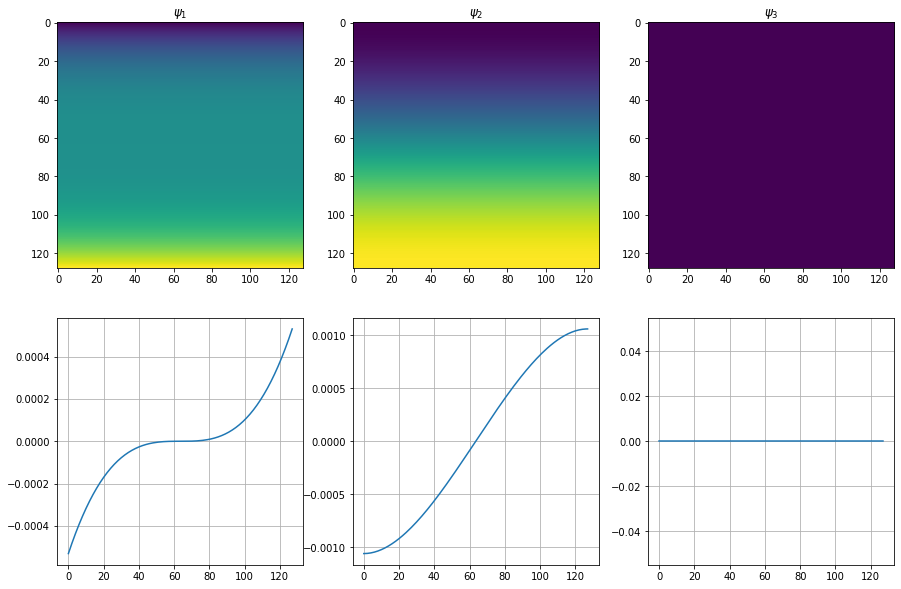

Q1+ = 0.0, target value: 0,
Q2+ = 0.0, target value: 0,
Q3+ = 8.488260391459335e-06, target value: 1e-05

Velocity distribution visualization without flow domain mask (first line) and with mask (second line)
-1.4216102073305592e-08 < v_1 < 1.4216102073305592e-08,
-7.108051036652796e-09 < v_2 < 3.554025518326398e-09,
-0.39776602387428284 < v_3 < 0.39777204394340515,
Q1- = -2.328306276076775e-13, Q1+ = 2.328306276076775e-13
Q2- = 0.0, Q2+ = 0.0
Q3- = 8.484114914608654e-06, Q3+ = 8.484114914608654e-06
Vabs[0,0,0] = 0.39776602387428284, Vabs[0,0,-1] = 0.39776602387428284, Vabs[0,-1,0] = 0.3977588713169098, Vabs[0,-1,-1] = 0.3977588713169098, Vabs[-1,0,0] = 0.39776602387428284, Vabs[-1,0,-1] = 0.39776602387428284, Vabs[-1,-1,0] = 0.3977588713169098, Vabs[-1,-1,-1] = 0.3977588713169098,


/opt/conda/lib/python3.7/site-packages/matplotlib/quiver.py:715: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
/opt/conda/lib/python3.7/site-packages/matplotlib/quiver.py:715: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


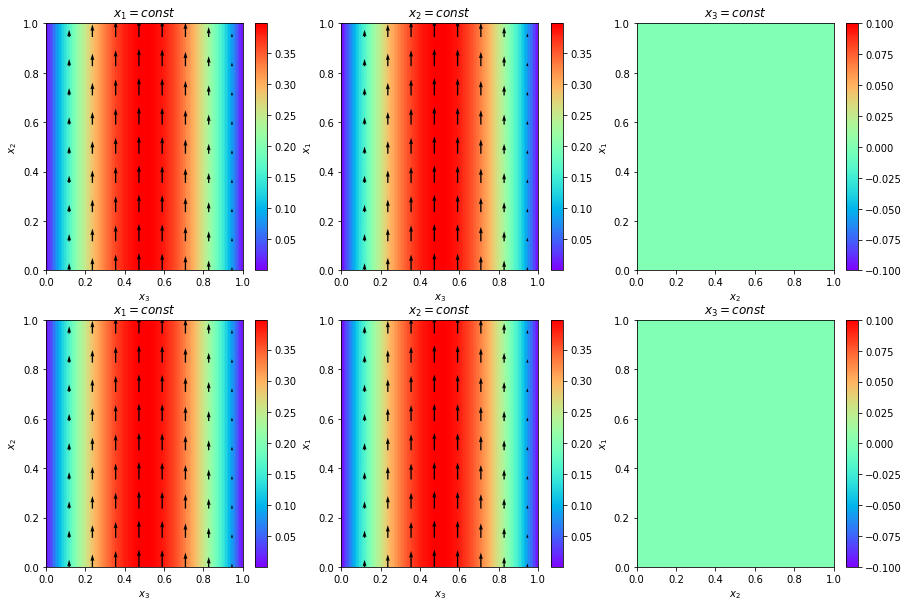

In [26]:
flowVisualization(psi.permute(1,0,2,3))

## Results

In [27]:
#Fix psi function on the boundaries
psi_masked = psi.clone().detach()
# for i in range(len(SIZE)):
#     psi_masked[i,:,:NL,:]  = psimm[i].to('cpu')
#     #psi_masked[i,:,-NL:,:] = psipp[i]
# psi_masked[0,:,-NL:,:] = psi_masked[0,0,-1,-1]    
# psi_masked[1,:,-NL:,:] = (Qp[2] + psi_masked[0,0,-1,-1]*L[0]) / L[1]
    
# psi_masked[2,:,-NL:,:] = psipp[2].to('cpu')
# psi_masked[2,0,:,0] = psimm[2].to('cpu')
# psi_masked[2,0,:,-1] = psipp[2].to('cpu')

        
v1, v2, v3 = velocityDistr(psi_masked[0,0,:,:], psi_masked[1,0,:,:], psi_masked[2,0,:,:], DX1N, DX2N, DX3N, L[0], L[1], L[2])
#v3[(X1N*L[0] - 0.5*L[0])**2 + (X2N*L[1] - 0.5*L[0])**2 > R**2] = 0

dv1dx1, dv2dx2, dv3dx3, divV  = divVel(v1, v2, v3, DX1N, DX2N, DX3N, L[0], L[1], L[2])

V = torch.stack([v1,v2,v3])
Vabs = torch.sqrt(v1**2 + v2**2 + v3**2)
xi11, xi12, xi13, xi22, xi23, xi33, EtaEta = TksiDistr(v1, v2, v3, DX1N, DX2N, DX3N, L[0], L[1], L[2])

#Subintegral expression with masks for fluid and walls, respectively:
subInt = ((0.5*Q0*EtaEta + ((Q1/(Z+1))*EtaEta**((Z+1)*0.5)))*img[0,:,:,:].to(DEVICE) +
          (0.5*Q0W*EtaEta + ((Q1W/(ZW+1))*EtaEta**((ZW+1)*0.5)))*(1-img[0,:,:,:].to(DEVICE))) 
#Integral
int1 = torch.trapz(subInt)
int2 = torch.trapz(int1)
int3 = torch.trapz(int2)
out = int3*dOmega #loss

print(f'absolute velocity: {Vabs.min()} < abs(V) < {Vabs.max()},')
print(f'mean velocity: {Vabs.mean()},')
print(f'internal power: Int = {out},')

absolute velocity: 1.5777259250171483e-06 < abs(V) < 0.39777204394340515,
mean velocity: 0.17914451658725739,
internal power: Int = 0.17459602653980255,


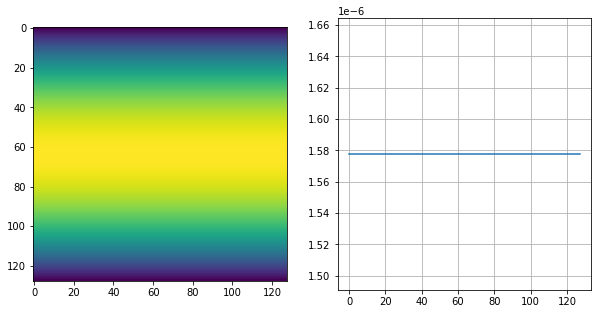

In [28]:
fig = plt.figure(figsize=(FIGSIZE*2, FIGSIZE))
plt.subplot(1,2,1)
plt.imshow(v3[0,:,:].to('cpu'))
#plt.title(f'$\psi_{i+1}$')
#plt.subplot(nr,nc,i+1+nc)
plt.subplot(1,2,2)
plt.plot(v3[0,slices[2],:].to('cpu'))
plt.grid()
plt.show()

In [29]:
def mv(f):
    print(f.min())
    print(f.max())
    print(f.mean())

In [30]:
mv(v3[0,:,:])

tensor(-0.3978, device='cuda:0')
tensor(1.5777e-06, device='cuda:0')
tensor(-0.1347, device='cuda:0')


Visualization

Psi function Visualization


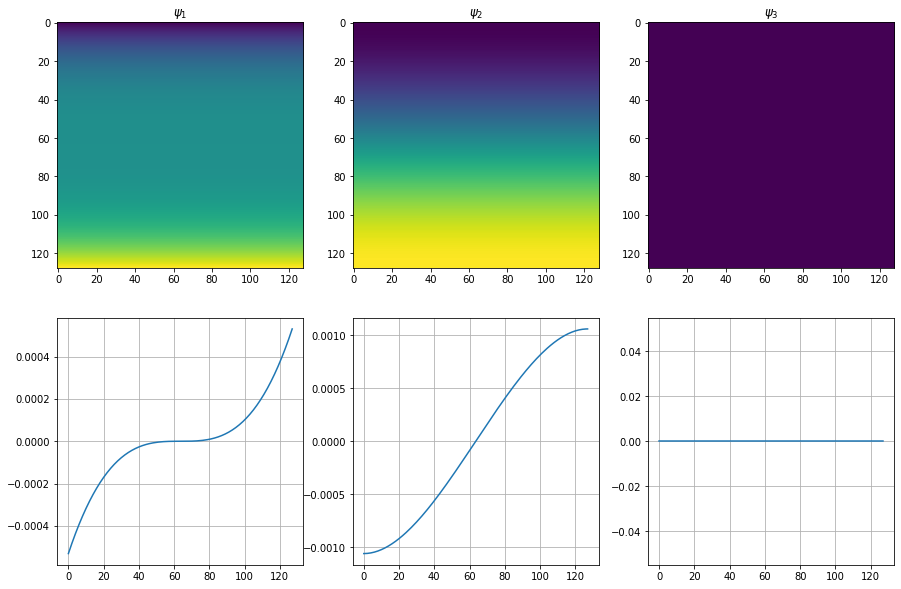

Q1+ = 0.0, target value: 0,
Q2+ = 0.0, target value: 0,
Q3+ = 8.488260391459335e-06, target value: 1e-05

Velocity distribution visualization without flow domain mask (first line) and with mask (second line)
-1.4216102073305592e-08 < v_1 < 1.4216102073305592e-08,
-7.108051036652796e-09 < v_2 < 3.554025518326398e-09,
-0.39776602387428284 < v_3 < 0.39777204394340515,
Q1- = -2.328306276076775e-13, Q1+ = 2.328306276076775e-13
Q2- = 0.0, Q2+ = 0.0
Q3- = 8.484114914608654e-06, Q3+ = 8.484114914608654e-06
Vabs[0,0,0] = 0.39776602387428284, Vabs[0,0,-1] = 0.39776602387428284, Vabs[0,-1,0] = 0.3977588713169098, Vabs[0,-1,-1] = 0.3977588713169098, Vabs[-1,0,0] = 0.39776602387428284, Vabs[-1,0,-1] = 0.39776602387428284, Vabs[-1,-1,0] = 0.3977588713169098, Vabs[-1,-1,-1] = 0.3977588713169098,


/opt/conda/lib/python3.7/site-packages/matplotlib/quiver.py:715: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
/opt/conda/lib/python3.7/site-packages/matplotlib/quiver.py:715: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


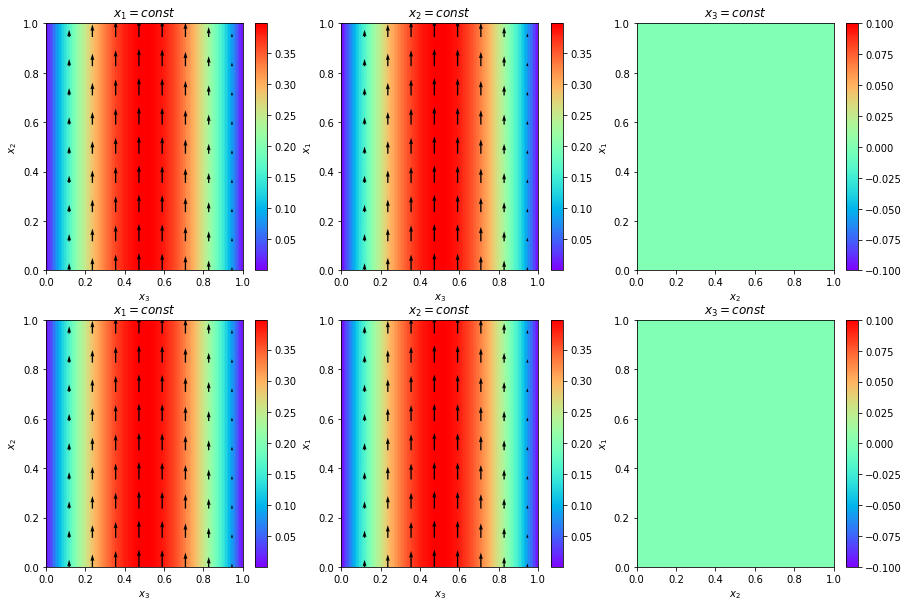

In [31]:
flowVisualization(psi_masked.permute(1,0,2,3))

Maximum velocity value in a slice

In [32]:
v3max = v3[slices[0],:,slices[2]].max()
v3max

tensor(0.3978, device='cuda:0')

Mean velocity in the flow domain

In [33]:
vabsmean = Vabs.mean()
vabsmean

tensor(0.1791, device='cuda:0')

In [34]:
Q3pch = int_func_simpson_2d(V[2, :, :,-1], L[0]*DX1N.to('cpu'), L[1]*DX2N.to('cpu'))
Q3pch

tensor(8.4841e-06, device='cuda:0')

In [35]:
#SIZE = (128, 128, 128)
#img = img[:, 14:-14, 14:-14, 14:-14]

torch.Size([128, 128, 128, 3])


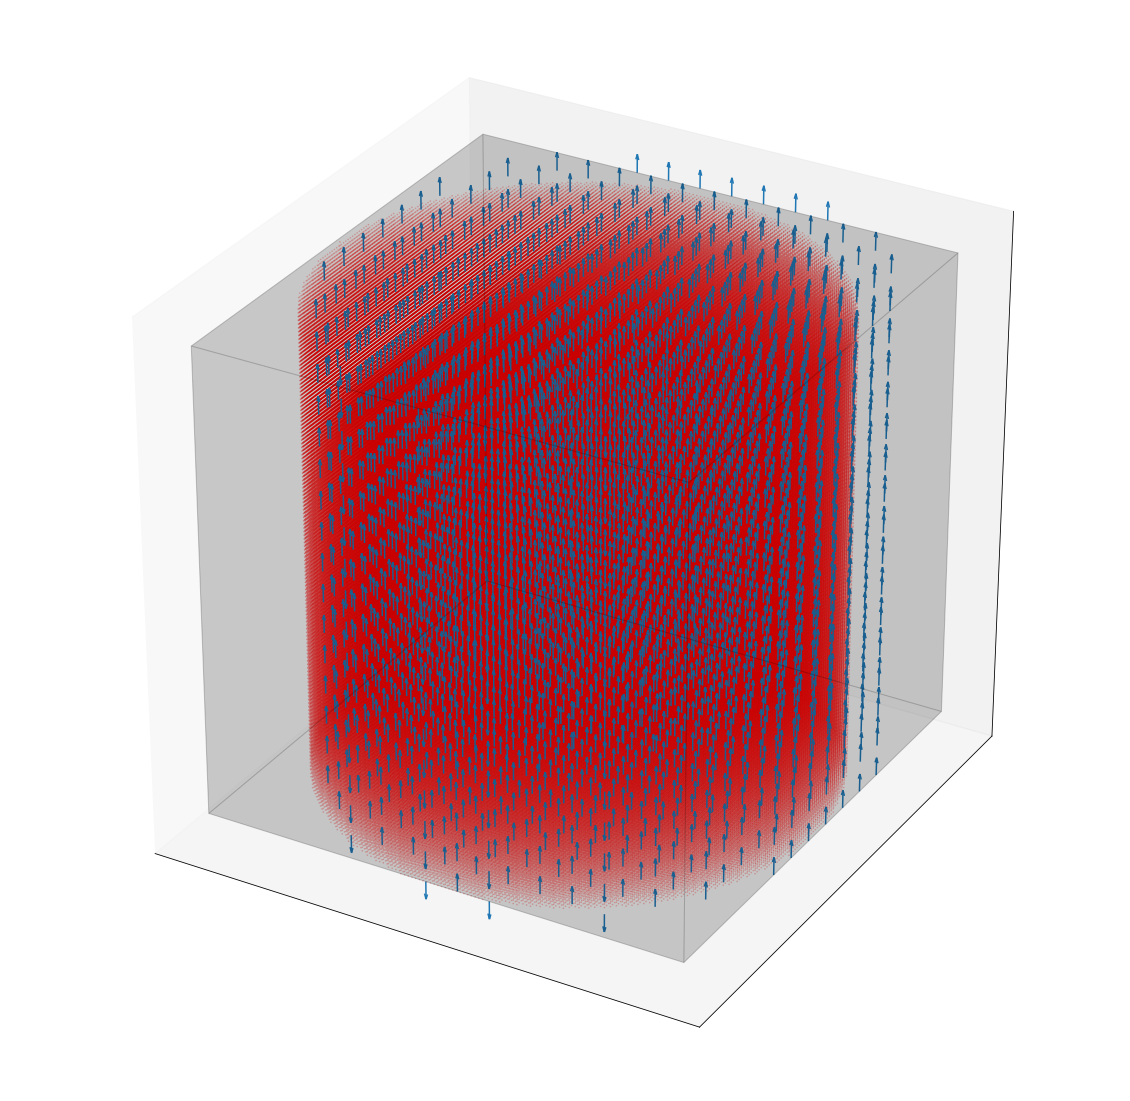

In [36]:
def vector_plot_3d(x, v, figSize=FIGSIZE, step=1):
    fig = plt.figure(figsize=(figSize, figSize))
    ax = fig.add_subplot(projection='3d')
    ax.quiver(x[0], x[1], x[2], v[::step, ::step, ::step, 0], v[::step, ::step, ::step, 1], v[::step, ::step, ::step, 2], length=5, normalize=True)
    pos = np.where(img[0].rot90().cpu().detach()==1)
    ax.scatter(pos[1], pos[0], pos[2], c='red', s=0.5, alpha=0.2)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.bar3d(0, 0, 0., SIZE[0], SIZE[1], SIZE[2], alpha=0.1, edgecolor='black', color='black')
    plt.show()
    
step = 8
x = np.meshgrid(np.linspace(0, SIZE[0], int(SIZE[0]/step)),
                np.linspace(0, SIZE[1], int(SIZE[1]/step)),
                np.linspace(0, SIZE[2], int(SIZE[2]/step)))
v_all = torch.stack((v1.cpu() * img[0], v2.cpu() * img[0], v3.cpu() * img[0]), 3)
print(v_all.size())
vector_plot_3d(x, v_all.cpu().detach().rot90(),figSize=FIGSIZE*4, step = step)

# Links

[1]. https://github.com/Mechanics-Mechatronics-and-Robotics/Mathematical_modelling/blob/main/Practice_1_by_IStebakov.ipynb

[2]. https://github.com/mateuszbuda/brain-segmentation-pytorch